## Read the data 


In [133]:
import pandas as pd
import numpy as np 
import re

In [134]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    file_data= pd.read_csv(f)
    data[f.replace('.csv','')] = file_data  

## Read the Surveys

In [135]:
all_surveys = pd.read_csv('survey_all.txt',delimiter = '\t', encoding='windows-1252')
d75_survey =  pd.read_csv('survey_d75.txt',delimiter = '\t', encoding='windows-1252')
survey = pd.concat([all_surveys,d75_survey],axis=0)
print(all_surveys.shape, d75_survey.shape, survey.shape)

(1646, 1942) (56, 1773) (1702, 2773)


In [136]:
survey["DBN"] = survey["dbn"]
#Based on the dictionary, it looks like these are the relevant columns:
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey[survey_fields]
data["survey"] = survey
print(survey.shape)

(1702, 23)


In [137]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results', 'survey'])

## Add DBN column in all data sets to make it consistent to combine the data sets 

In [138]:
#Add DBN column for Class_size data set . DBN column is a combination of CSD and School Code 
#This function will append 0 if the CSD has a single digit 
def update_csd(ele):
    csd=str(ele)
    if len(csd) ==1:
        csd='0'+csd
    return csd

      
data["class_size"]['CSD'] = data["class_size"]['CSD'].apply(update_csd)
data["class_size"]['DBN'] = data["class_size"]['CSD'] + data["class_size"]['SCHOOL CODE']

data["class_size"]['DBN'].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

In [139]:
# Rename dbn column in hs_directory to DBN 
data["hs_directory"] = data["hs_directory"].rename(columns={'dbn':'DBN'})
data["hs_directory"].columns

Index(['DBN', 'school_name', 'boro', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'zip', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'priority05', 

## Convert columns to numeric

In [140]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for col in cols:
    data['sat_results'][col] = pd.to_numeric(data['sat_results'][col],errors='coerce')
    
data['sat_results']['sat_score']=data['sat_results'][cols].sum(axis=1)
    
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


In [141]:
#Extract the latitude and longitude
data['hs_directory']['lat']=data['hs_directory']['Location 1'].str.findall("\(.+\)").str[0].str.replace("(","").str.replace(")","").str.split(",").str[0]
data['hs_directory']['lon']=data['hs_directory']['Location 1'].str.findall("\(.+\)").str[0].str.replace("(","").str.replace(")","").str.split(",").str[1]

data['hs_directory']['lat']= pd.to_numeric(data['hs_directory']['lat'],errors= 'coerce')
data['hs_directory']['lon']= pd.to_numeric(data['hs_directory']['lon'],errors= 'coerce')


## Condense data sets

In [142]:
# Class Size data set 
class_size= data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
class_size= class_size.groupby('DBN').mean()
class_size.reset_index(inplace= True)
data['class_size'] = class_size
data['class_size'].head()

,DBN,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,57.6000,2.733333,21.200000,19.40,22.866667,NaN


In [143]:
#Dempgraphics data set 
data["demographics"] = data["demographics"][data["demographics"]['schoolyear']==20112012]

In [144]:
#Graduation data set 
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]


## Convert AP scores to numeric

In [145]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for col in cols:
    data['ap_2010'][col]= pd.to_numeric(data['ap_2010'][col],errors = "coerce")

## Combine the data sets 

In [146]:
combined = data["sat_results"]
combined = pd.merge( left = combined, right = data['ap_2010'], on = 'DBN', how = 'left')
combined = pd.merge( left = combined, right = data['graduation'], on = 'DBN', how = 'left')
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

In [147]:
combined['school_dist']= combined['DBN'].str[:2]

## Find correlations

In [148]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)


SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SAT Writing Avg. Score             0.472854
sat_score                          1.000000
AP Test Takers                     0.254925
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.080811
lon                               -0.048274
Name: sat_score, Length: 66, dtype: float64


## Plotting survey correlations

In [149]:
survey_fields.remove("DBN")

In [150]:
combined.corr()["sat_score"]

SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SAT Writing Avg. Score             0.472854
sat_score                          1.000000
AP Test Takers                     0.254925
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.080811
lon                               -0.048274
Name: sat_score, Length: 66, dtype: float64

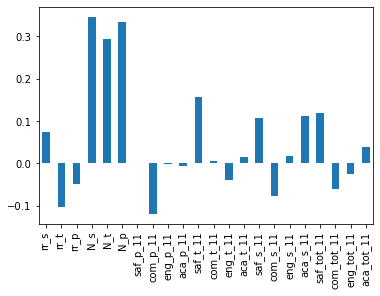

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.show()



There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.


## Exploring Safety

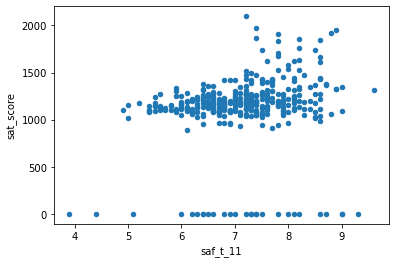

In [152]:
combined.plot.scatter(x='saf_t_11', y= 'sat_score')
plt.show()

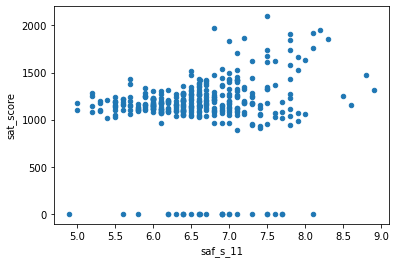

In [153]:
combined.plot.scatter(x='saf_s_11', y= 'sat_score')
plt.show()



There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.


## Borough safety

In [154]:
boros =combined.groupby('boro').agg(np.mean)['saf_s_11'].sort_values(ascending = False)
print(boros)

boro
Manhattan        6.831370
Queens           6.721875
Bronx            6.606577
Staten Island    6.530000
Brooklyn         6.370755
Name: saf_s_11, dtype: float64


In [155]:
combined.groupby('boro').agg(np.mean)['sat_score'].sort_values(ascending = False)

boro
Staten Island    1382.500000
Queens           1191.171875
Manhattan        1128.800000
Brooklyn         1112.113208
Bronx            1078.666667
Name: sat_score, dtype: float64

It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Racial differences in SAT scores

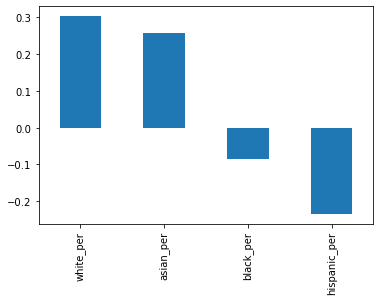

In [156]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()['sat_score'][race_fields].plot.bar()
plt.show()

It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

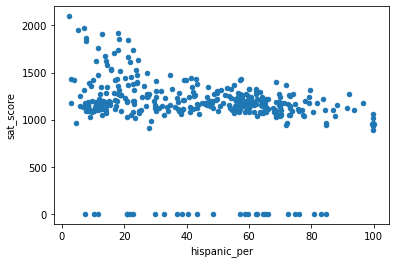

In [157]:
combined.plot.scatter(x='hispanic_per', y= 'sat_score')

<AxesSubplot:xlabel='black_per', ylabel='sat_score'>

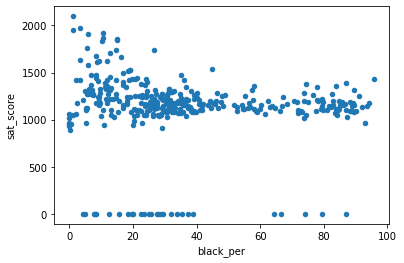

In [158]:
combined.plot.scatter(x='black_per', y= 'sat_score')

In [159]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [160]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender differences in SAT scores

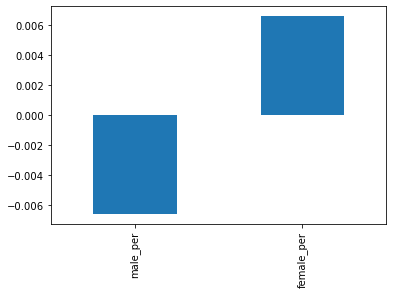

In [172]:
combined.corr()['sat_score'][['male_per','female_per']].plot.bar()
plt.show()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.


<AxesSubplot:xlabel='male_per', ylabel='sat_score'>

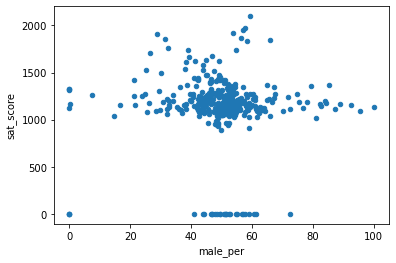

In [161]:
combined.plot.scatter(x='male_per',y='sat_score')

<AxesSubplot:xlabel='female_per', ylabel='sat_score'>

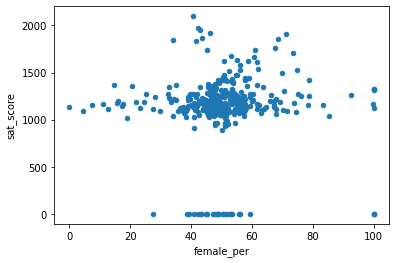

In [162]:
combined.plot.scatter(x='female_per',y='sat_score')

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [173]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

In [190]:
for col in combined.columns:
    if 'Size' in col:
        print(col)

In [175]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

(700.0, 2500.0)

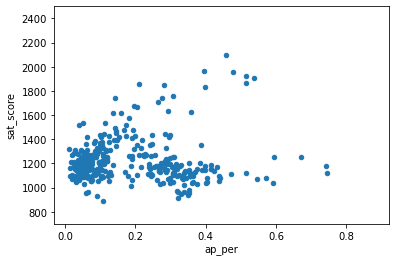

In [178]:
combined.plot.scatter(x='ap_per',y='sat_score')
plt.ylim(700,2500)



It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.


## Class Size and SAT scores

<AxesSubplot:xlabel='AVERAGE CLASS SIZE', ylabel='sat_score'>

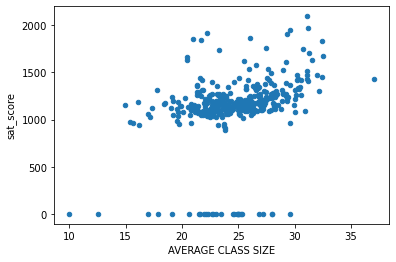

In [192]:
combined.plot.scatter(x='AVERAGE CLASS SIZE',y='sat_score')

It looks like there is a relationship between the class size and  and their average SAT scores.